<a href="https://colab.research.google.com/github/JurugoBrian/MoE_Models/blob/main/MoEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install split-folders

In [ ]:
# Import necessary libraries
import os
from google.colab import drive
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
import splitfolders
import pandas as pd

In [ ]:
print(splitfolders.__version__)

0.5.1


In [ ]:
# Mount Google Drive and Load Datasets and define the paths to the datasets
drive.mount('/content/drive')
input_dir = '/content/drive/MyDrive/2025/MCSC_Research/cancer_dataset/input'     # Base directory containing the dataset
output_dir = '/content/drive/MyDrive/2025/MCSC_Research/cancer_dataset/output'  # Output directory where the split datasets will be stored
classes = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']  # Define the classes

# Split ration
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


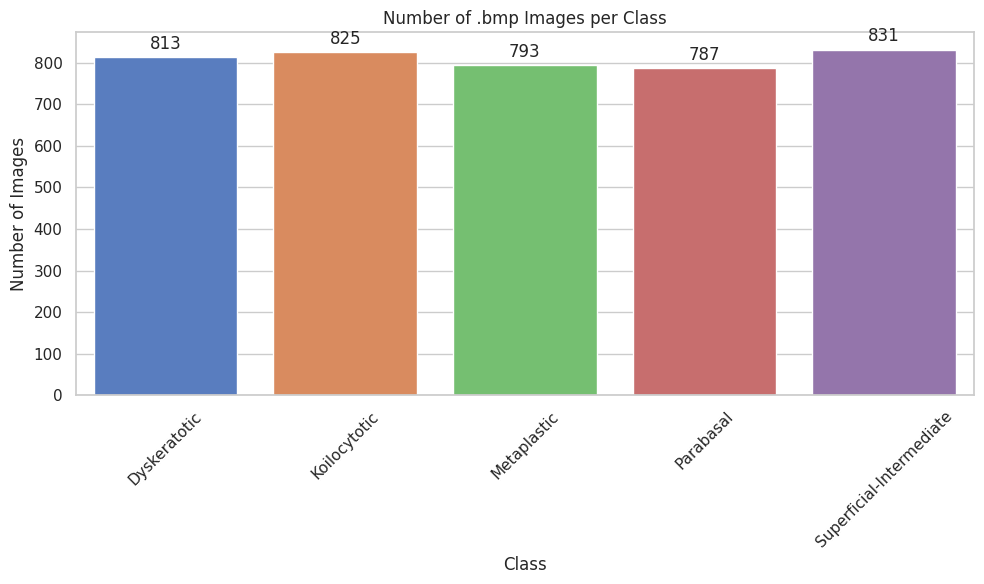

In [ ]:

# Initialize a dictionary to hold class names and their image counts
class_counts = {}

# Iterate over each class directory in the input directory
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of .bmp images in the class directory
        image_count = len([
            file for file in os.listdir(class_path)
            if file.lower().endswith('.bmp')
        ])
        class_counts[class_name] = image_count

# Check if any classes were found
if not class_counts:
    print(f"No class directories with .bmp images found in {input_dir}.")
else:
    # Create a DataFrame from the class_counts dictionary
    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='Class', y='Count', hue='Class', palette='muted', legend=False)

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

    # Set plot labels and title
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of .bmp Images per Class')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [ ]:
# Visualize a sample of images from each of the 5 classes

# Retrieve the list of class names (subdirectory names)
class_names = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]

# Initialize lists to store images and their corresponding class labels
images = []
labels = []

# Iterate over each class to select one random image
for class_name in class_names:
    class_path = os.path.join(input_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith('.bmp')]
    if image_files:
        selected_image = random.choice(image_files)
        image_path = os.path.join(class_path, selected_image)
        try:
            img = Image.open(image_path)
            images.append(img)
            labels.append(class_name)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

# Determine the number of images to display
num_images = len(images)

# Set up the plot
plt.figure(figsize=(15, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# The input data is copied to out_dir and split into training, validation, and testing sets
splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=(.8, .1, .1))

Copying files: 4049 files [02:57, 22.82 files/s]


In [ ]:
# Data augmentation pipeline using the Kera preprocessing layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
# Apply augmentation to the training dataset using the map function
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE)

In [ ]:
# Optimize the datasets for performance by using prefetch function
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Visualize a few images to ensure that preprocessing has worked correctly

# Function to display images
def display_images(dataset):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(9)):  # Display 9 images
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0])  # Display first image in batch
        plt.title(str(label[0].numpy()))  # Display label
        plt.axis("off")
    plt.show()

# Display a batch of images
display_images(train_ds)

In [ ]:
# Number of classes in the SIPAKMED dataset
num_classes = 5

# Function to create an expert model
def create_expert_model(model_url, input_shape=(224, 224, 3)):
    # Load pre-trained model from TensorFlow Hub
    base_model = hub.KerasLayer(model_url, trainable=True)

    # Define the model architecture
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# URLs of pre-trained models on TensorFlow Hub
model_urls = {
    "ResNet101": "https://tfhub.dev/tensorflow/resnet_101/feature_vector/5",
    "EfficientNetB7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
    "InceptionV3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",
    "Xception": "https://tfhub.dev/google/imagenet/xception/feature_vector/5",
    "DenseNet": "https://tfhub.dev/tensorflow/densenet121/feature-vector/1",
    "EfficientNetV2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
    "ViT": "https://tfhub.dev/sayakpaul/vit_b16_fe/1",
    "SwinTransformer": "https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224_fe/1"
}

# Create expert models
experts = [create_expert_model(url) for url in model_urls.values()]


In [ ]:
# Define the gating network (The gating network takes the same input and outputs a probability distribution over the experts)
def create_gating_network():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(experts), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

gating_network = create_gating_network()

In [ ]:
# Define the MoE model (A custom TensorFlow model that integrates the experts and the gating network.)
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, experts, gating_network):
        super(MixtureOfExperts, self).__init__()
        self.experts = experts
        self.gating_network = gating_network

    def call(self, inputs):
        # Get gating weights
        gating_weights = self.gating_network(inputs)

        # Get expert outputs
        expert_outputs = [expert(inputs) for expert in self.experts]

        # Stack expert outputs
        expert_outputs = tf.stack(expert_outputs, axis=-1)

        # Weight expert outputs by gating weights
        weighted_outputs = expert_outputs * tf.expand_dims(gating_weights, axis=-2)

        # Sum weighted outputs
        output = tf.reduce_sum(weighted_outputs, axis=-1)

        return output

# Instantiate the MoE model
moe_model = MixtureOfExperts(experts, gating_network)

In [ ]:
# Compile and train the MoE model
moe_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = moe_model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=validation_dataset,  # Replace with your validation dataset
    epochs=10
)
